<a href="https://colab.research.google.com/github/suchismita-shaw/Differential-Gene-Expression-Analysis-in-Lung-Cancer/blob/main/Differential_Gene_Expression_Analysis_in_Lung_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
file_paths= ['SRR27126025all_counts1.csv',
             'SRR27126026all_counts1.csv',
             'SRR27126027all_counts1.csv',
             'SRR27126028all_counts1.csv',
             'SRR27126029all_counts1.csv',
             'SRR27126030all_counts1.csv']

In [ ]:
merged_df= pd.read_csv(file_paths[0])

In [ ]:
for file in file_paths[1:]:
  df = pd.read_csv(file)
  merged_df = pd.merge(merged_df, df, on ="Geneid" , how = 'inner')

In [ ]:
merged_df.head()

,Geneid,SRR27126025_sorted.bam,SRR27126026_sorted.bam,SRR27126027_sorted.bam,SRR27126028_sorted.bam,SRR27126029_sorted.bam,SRR27126030_sorted.bam
0,ENSG00000279928,0,0,0,0,0,0
1,ENSG00000228037,0,11,13,13,13,8
2,ENSG00000142611,2,8,11,7,7,9
3,ENSG00000284616,0,0,0,0,0,0
4,ENSG00000157911,494,591,570,521,521,496


In [ ]:
merged_df.to_csv('merged_dataset.csv', index=False)
print("Merged shape:", merged_df.shape)

Merged shape: (62754, 7)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv('/content/Lung_cancer_dataset.csv')  # adjust if you're pasting from Excel

# Set gene IDs as index
data.set_index('Geneid', inplace=True)

# Convert all data to numeric
data = data.apply(pd.to_numeric)

# Optional: visualize a few rows
print(data.head())


                 NCAPD3 Knockdown1  NCAPD3 Knockdown2  NCAPD3 Knockdown3  \
Geneid                                                                     
ENSG00000279928                  0                  0                  0   
ENSG00000228037                  0                 11                 13   
ENSG00000142611                  2                  8                 11   
ENSG00000284616                  0                  0                  0   
ENSG00000157911                494                591                570   

                 Wild.Type1  Wild Type2  Wild Type3  
Geneid                                               
ENSG00000279928           0           0           0  
ENSG00000228037          13          13           8  
ENSG00000142611           7           7           9  
ENSG00000284616           0           0           0  
ENSG00000157911         521         521         496  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv('/content/Lung_cancer_dataset.csv')  # adjust if you're pasting from Excel


In [ ]:
data.head()

,Geneid,NCAPD3 Knockdown1,NCAPD3 Knockdown2,NCAPD3 Knockdown3,Wild.Type1,Wild Type2,Wild Type3
0,ENSG00000279928,0,0,0,0,0,0
1,ENSG00000228037,0,11,13,13,13,8
2,ENSG00000142611,2,8,11,7,7,9
3,ENSG00000284616,0,0,0,0,0,0
4,ENSG00000157911,494,591,570,521,521,496


# **Visualize Raw Counts (Log2 Boxplot)**

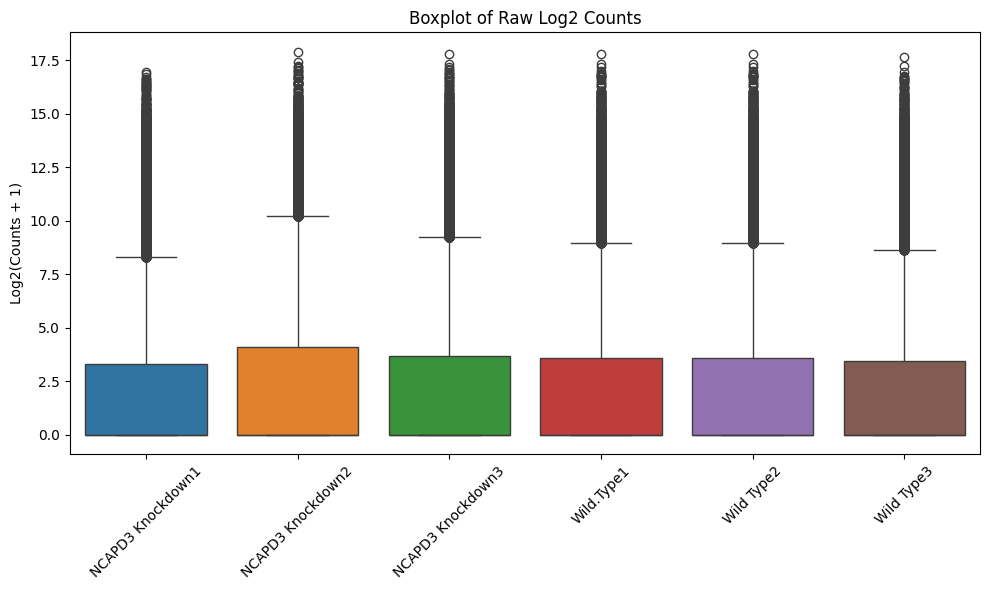

In [ ]:
# Add pseudocount to avoid log(0)
log2_data = np.log2(data + 1)

plt.figure(figsize=(10, 6))
sns.boxplot(data=log2_data)
plt.xticks(rotation=45)
plt.title("Boxplot of Raw Log2 Counts")
plt.ylabel("Log2(Counts + 1)")
plt.tight_layout()
plt.show()


# **Normalize with Log2 Counts per Million (CPM)**

In [ ]:
def log2_cpm(df):
    counts_sum = df.sum(axis=0)
    cpm = df.div(counts_sum, axis=1) * 1e6
    log2_cpm = np.log2(cpm + 1)
    return log2_cpm

log2cpm_data = log2_cpm(data)


# **. Boxplot After Normalization**

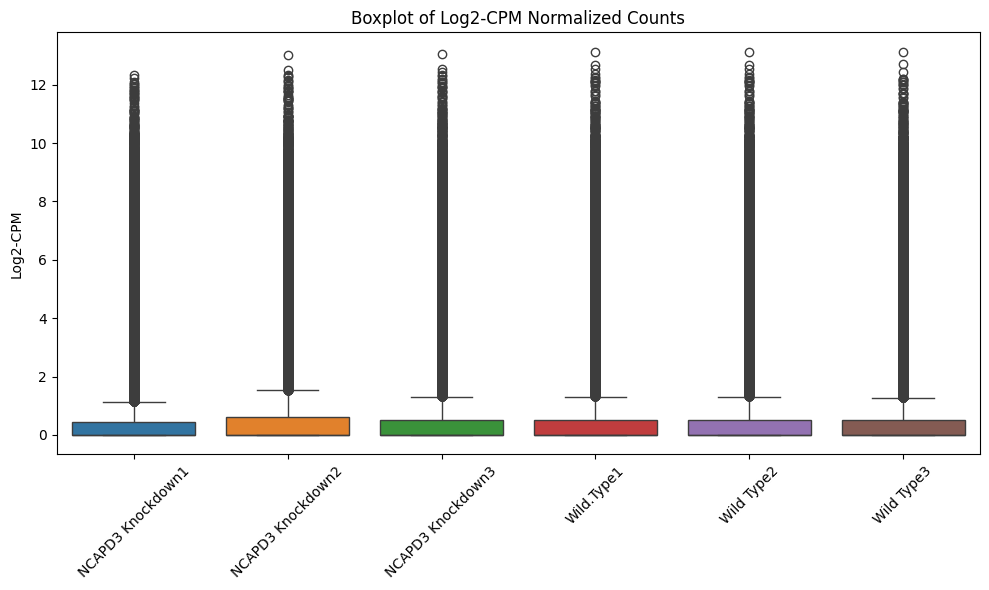

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=log2cpm_data)
plt.xticks(rotation=45)
plt.title("Boxplot of Log2-CPM Normalized Counts")
plt.ylabel("Log2-CPM")
plt.tight_layout()
plt.show()


# Assessing Suitability for DGE
**variation between conditions, so do PCA to inspect clustering**

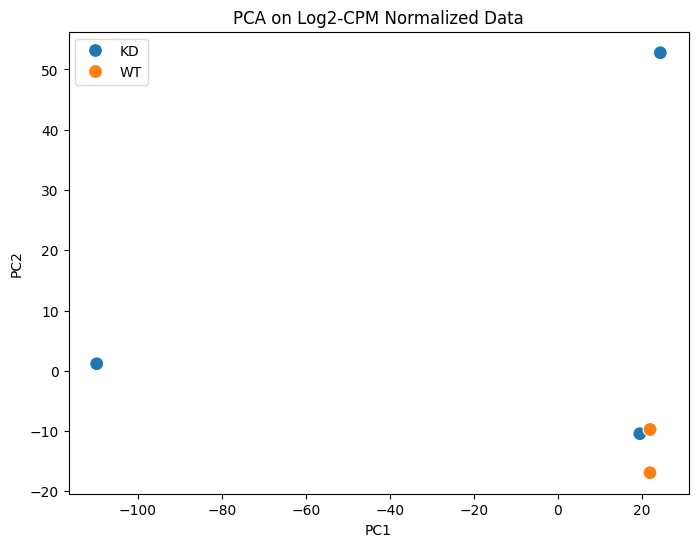

In [ ]:
from sklearn.decomposition import PCA

# Transpose for PCA (samples as rows)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log2cpm_data.T)

# Create condition labels manually
conditions = ['KD']*3 + ['WT']*3

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=conditions, s=100)
plt.title("PCA on Log2-CPM Normalized Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [1]:
import pandas as pd

# Load your data
df = pd.read_csv("/content/DEG_results.csv", index_col=0)

# For example: label genes with |log2FoldChange| > 1 and padj < 0.05 as 'biomarker'
df['label'] = ((abs(df['log2FoldChange']) > 1) & (df['padj'] < 0.05)).astype(int)


In [2]:
features = ['baseMean', 'log2FoldChange', 'pvalue', 'padj', 'stat']
X = df[features]
y = df['label']


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8915
           1       0.91      1.00      0.95        10

    accuracy                           1.00      8925
   macro avg       0.95      1.00      0.98      8925
weighted avg       1.00      1.00      1.00      8925

AUC Score: 1.0


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("/content/Lung_cancer_dataset.csv")

In [7]:
df

,Geneid,NCAPD3 Knockdown1,NCAPD3 Knockdown2,NCAPD3 Knockdown3,Wild.Type1,Wild Type2,Wild Type3
0,ENSG00000279928,0,0,0,0,0,0
1,ENSG00000228037,0,11,13,13,13,8
2,ENSG00000142611,2,8,11,7,7,9
3,ENSG00000284616,0,0,0,0,0,0
4,ENSG00000157911,494,591,570,521,521,496
...,...,...,...,...,...,...,...
62749,ENSG00000271254,156,722,615,625,625,649
62750,ENSG00000275987,0,0,0,0,0,0
62751,ENSG00000268674,0,0,0,0,0,0
62752,ENSG00000277475,0,0,0,0,0,0


In [9]:
df_long = df.set_index('Geneid').T
df_long.index.name = 'sample'

In [10]:
df_long['label'] = df_long.index.map(lambda x: x.split('_')[0])

In [15]:
print(df_long['label'].value_counts())


label
NCAPD3 Knockdown1    1
NCAPD3 Knockdown2    1
NCAPD3 Knockdown3    1
Wild.Type1           1
Wild Type2           1
Wild Type3           1
Name: count, dtype: int64


In [16]:
counts = df_long['label'].value_counts()
valid_classes = counts[counts >= 2].index
df_long = df_long[df_long['label'].isin(valid_classes)]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                   precision    recall  f1-score   support

NCAPD3 Knockdown1       0.00      0.00      0.00       1.0
NCAPD3 Knockdown2       0.00      0.00      0.00       1.0
NCAPD3 Knockdown3       0.00      0.00      0.00       0.0
       Wild Type3       0.00      0.00      0.00       0.0

         accuracy                           0.00       2.0
        macro avg       0.00      0.00      0.00       2.0
     weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [20]:
importances = clf.feature_importances_
gene_names = X.columns
importance_df = pd.DataFrame({'gene': gene_names, 'importance': importances})
top_genes = importance_df.sort_values(by='importance', ascending=False).head(10)

In [21]:
print("\nTop 10 Biomarker Genes:")
print(top_genes)


Top 10 Biomarker Genes:
                  gene  importance
40487  ENSG00000278973    0.010989
19264  ENSG00000218027    0.010989
36062  ENSG00000166796    0.010989
15818  ENSG00000151552    0.010989
37893  ENSG00000107745    0.010989
6060   ENSG00000071082    0.010989
13540  ENSG00000189308    0.010989
58582  ENSG00000060566    0.010989
49309  ENSG00000227827    0.010989
46852  ENSG00000103932    0.010989


In [23]:
pip install mygene


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.8 MB/s eta 0:00:00


In [24]:
import mygene

mg = mygene.MyGeneInfo()
gene_ids = top_genes['gene'].tolist()

# Query gene symbols from Ensembl IDs
gene_info = mg.querymany(gene_ids, scopes='ensembl.gene', fields='symbol', species='human')

# Convert to DataFrame and merge
import pandas as pd
gene_df = pd.DataFrame(gene_info)
top_genes_named = top_genes.merge(gene_df[['query', 'symbol']], left_on='gene', right_on='query', how='left')
top_genes_named = top_genes_named[['symbol', 'importance']].rename(columns={'symbol': 'gene_name'})

print("\nTop 10 Biomarker Genes with Names:")
print(top_genes_named)


INFO:biothings.client:querying 1-10 ...
INFO:biothings.client:Finished.



Top 10 Biomarker Genes with Names:
  gene_name  importance
0       NaN    0.010989
1    ELF2P2    0.010989
2      LDHC    0.010989
3      QDPR    0.010989
4     MICU1    0.010989
5     RPL31    0.010989
6     LIN54    0.010989
7   CREB3L3    0.010989
8    PKD1P2    0.010989
9     RPAP1    0.010989


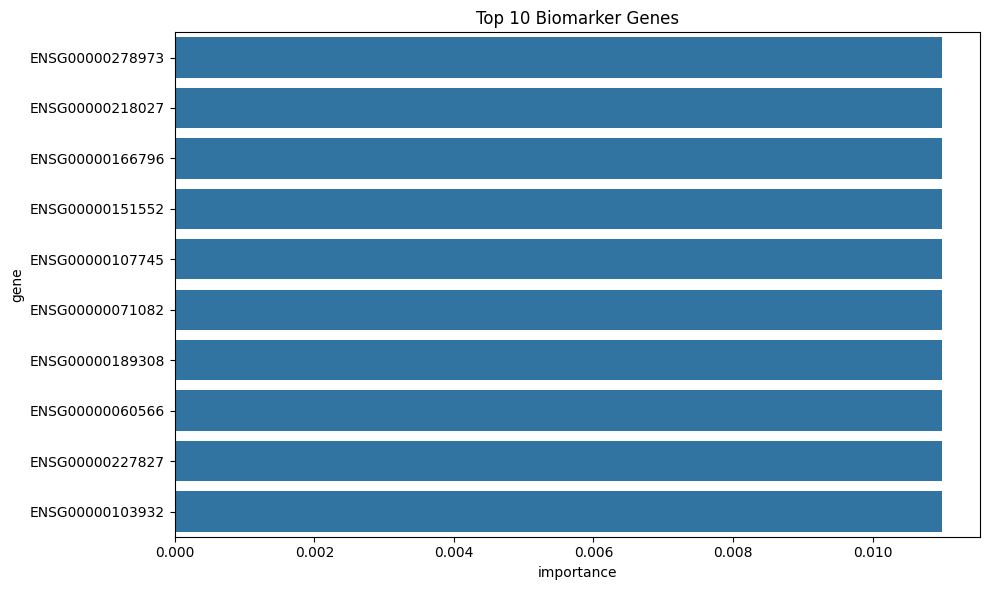

In [25]:
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='gene', data=top_genes)
plt.title("Top 10 Biomarker Genes")
plt.tight_layout()
plt.show()